In [1]:
import pennylane as qml
import pennylane.numpy as np
from model import Model

In [2]:
name = 'oren_nayar_simplified_v-s-ti-to-p'

rho = 1
E0 = 1


def func(sigma, theta_i, theta_o, phi):
	alpha = max(theta_i, theta_o)
	beta = min(theta_i, theta_o)

	A = 1 - (sigma**2 / (2 * (sigma**2 + 0.33)))
	B = 0.45 * sigma**2 / (sigma**2 + 0.09)

	R = rho * E0 * np.cos(theta_i)

	return R / np.pi * (A + B * max(0, np.cos(phi)) * np.sin(alpha) * np.tan(beta))


consts = {'': 0}
scalars = {
	'sigma': {'range': (0., 0.6), 'type': np.float32},
}
angles = {
	# 'theta_i': {'range': (0, np.pi / 2)},
	'theta_i': {'range': (0, np.pi / 2)},
	# 'phi_i': {'range': (0, np.pi / 2)},
	'theta_o': {'range': (0, np.pi / 2)},
	# 'phi': {'range': (0, np.pi / 2)},
	'phi': {'range': (0, np.pi)},
}

In [3]:
model = Model(name=name)
model.set_function(func)
# model.set_consts(consts)
model.set_scalars(scalars)
model.set_angles(angles)

model.SAMPLE_COUNT = 40_000
model.set_sample_size(800)

try:
	model.read_samples('samples/' + model.name + '.bin')
except FileNotFoundError:
	model.generate_samples()
	model.read_samples('samples/' + model.name + '.bin')

model.separate()

(<Figure size 40300x500 with 1 Axes>, <Axes: >)

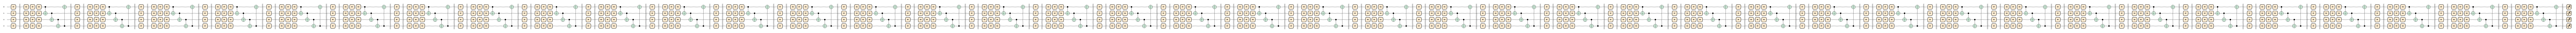

In [4]:
n_qubits = len(model.scalars) + len(model.angles)
layers = 40

model.push_extra('n_qubits',n_qubits)
model.push_extra('layers',layers)

model.generate_device(n_qubits)


def embedding(data, n_qubits, params):
	for i in range(n_qubits):
		if i < len(model.scalars):
			value = data[i]
			name = model.header[i + len(model.consts)]
			(min, max) = model.scalars.get(name).get('range')
			if min == max:
				value = 0.5
			else:
				value = (((value - min) / (max - min)) * 2 - 1) * np.pi
			qml.RY(params[i] * value, wires= i)
		else:
			value = data[i]
			name = model.header[i + len(model.consts)]
			(min, max) = model.angles.get(name).get('range')
			qml.RY(params[i] * data[i], wires=i)

	qml.Barrier()

	return


def rot_ent(params, n_qubits):
	if len(params) < n_qubits * 3:
		raise ValueError('Not enough params')

	for i in range(n_qubits):
		qml.RX(params[3 * i], wires=i)
		qml.RY(params[3 * i + 1], wires=i)
		qml.RX(params[3 * i + 2], wires=i)

	for i in range(n_qubits):
		qml.CNOT(wires=[i, (i + 1) % n_qubits])

	qml.Barrier()

	return

model.push_extra('embedding',embedding)
model.push_extra('rot_ent',rot_ent)


def _circuit(data, params):
	n_qubits = model.extra.get('n_qubits')
	layers = model.extra.get('layers')
	embedding = model.extra.get('embedding')
	rot_ent = model.extra.get('rot_ent')
	for i in range(layers):
		temp_params = params[i * n_qubits * 4 : (i + 1) * n_qubits * 4 ]
		embedding(data, n_qubits, temp_params[:n_qubits])

		rot_ent(temp_params[n_qubits : ], n_qubits)

	return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))


def _model(circ, input, params):
	return (circ(input, params) + 1) / 2


model.set_model(_model)
model.set_circuit(_circuit)
model.generate_params((n_qubits * 4 * layers,))

qml.draw_mpl(model.circuit, style='sketch')(model.train_in, model.params)

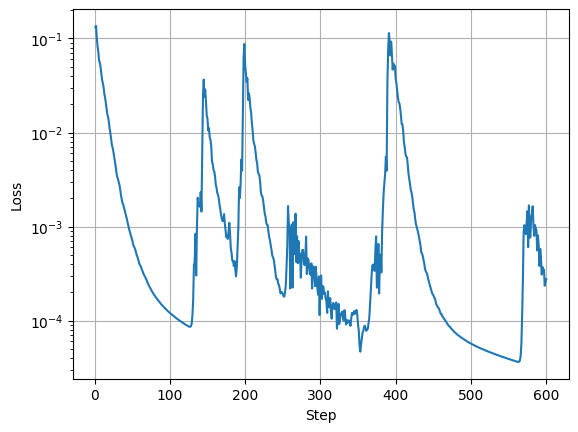

Loss: 0.0002752893505955614
Step 600
Estimated time remaining: 00:00:00:000


In [ ]:
model.set_max_steps(40)
model.set_objective(1E-6)
model.optimization(objective=True, callback= 'graph')

In [5]:
print('Test score:', model.test())

Test score: 0.1233945759729998


In [19]:
model.loss(model.params,model.train_in,model.train_out)

tensor(3.6625736e-05, requires_grad=True)

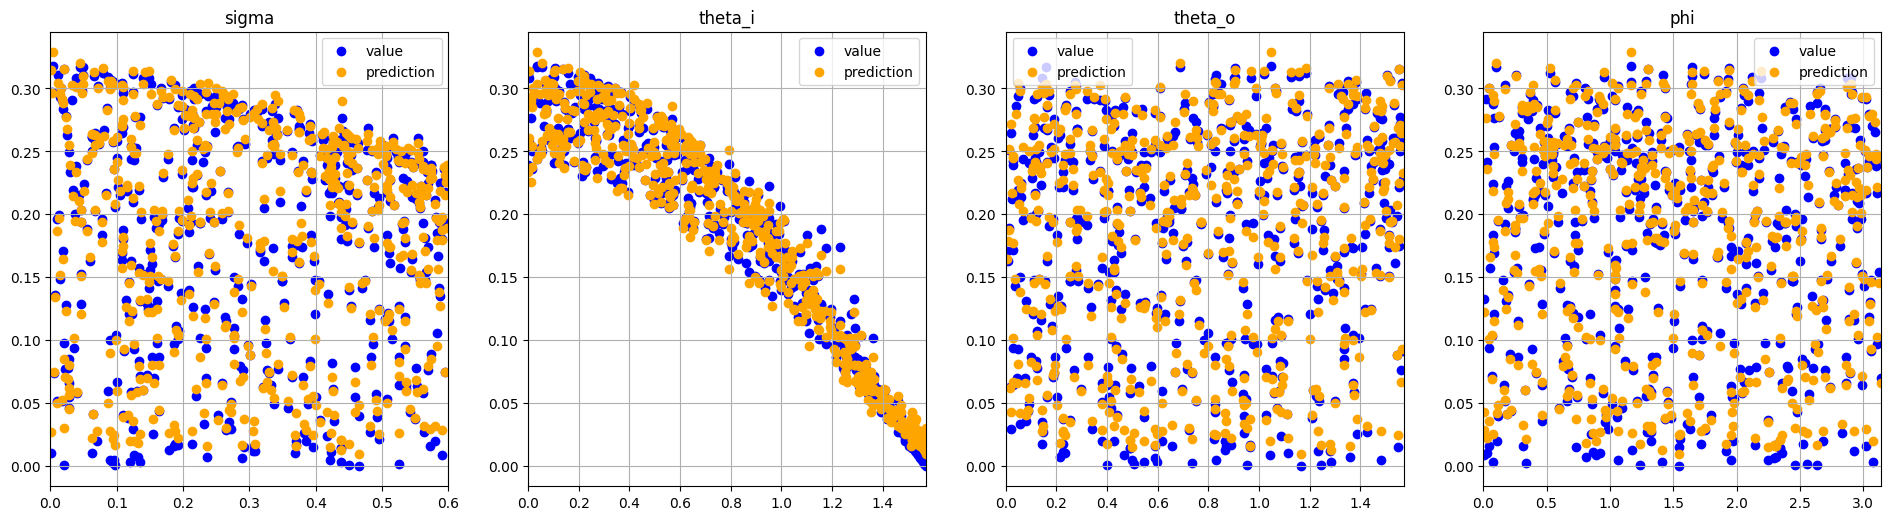

In [8]:
model.draw_train()

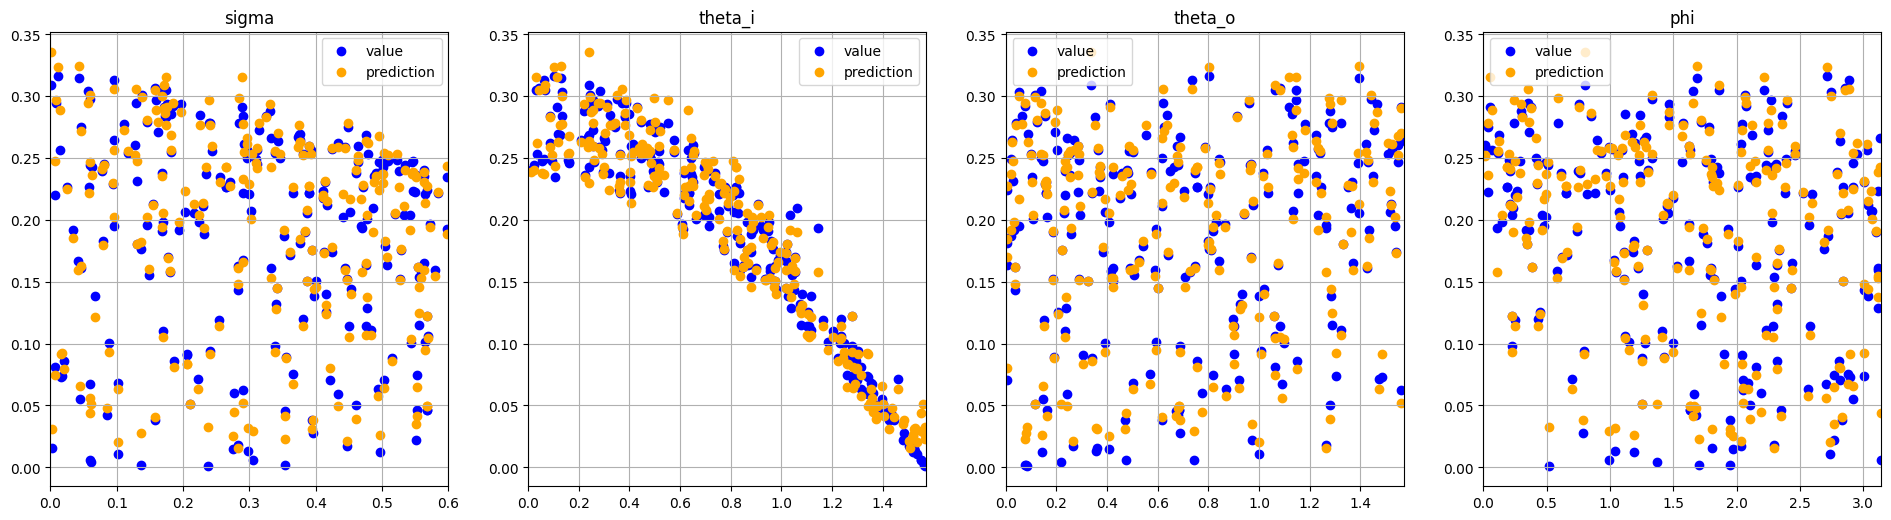

In [9]:
model.draw()

In [26]:
model.serialize('models/' + model.name + '.json', samples=True)

/tmp/ipykernel_2948/3286729588.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


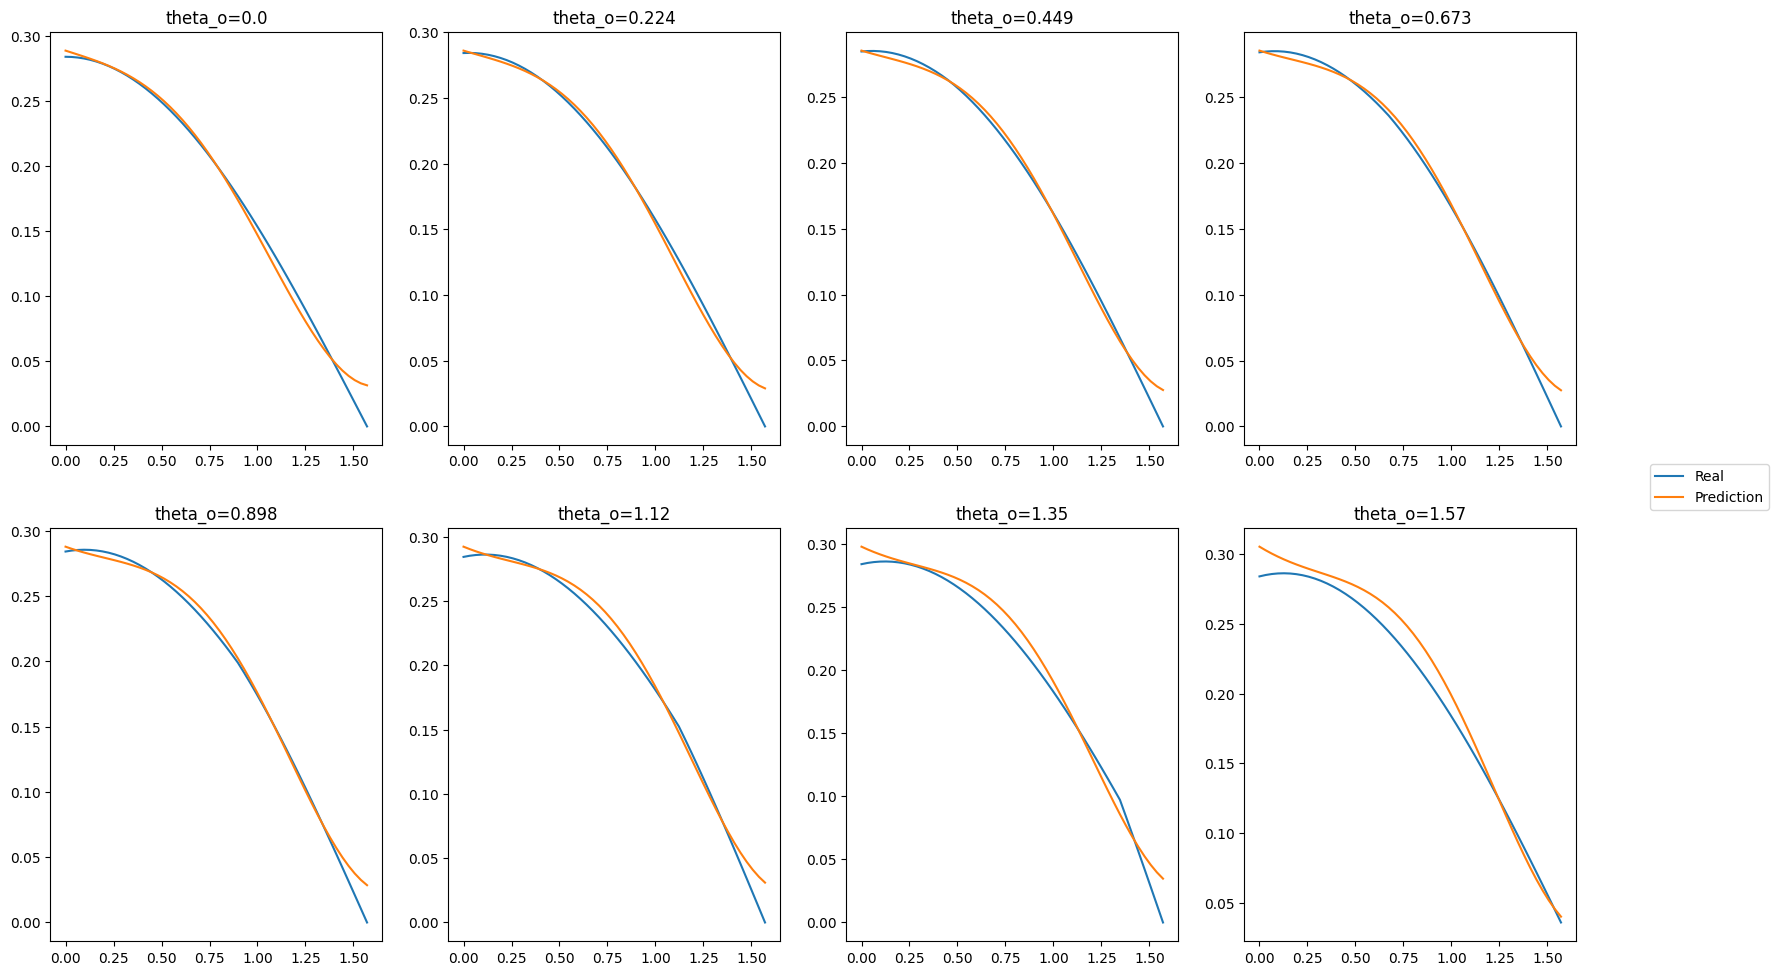

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

fig = plt.figure(
	figsize=(50 * 1 / 2.54, 15 * 2 * 1 / 2.54),
)

axs = [fig.add_subplot(2, 4, i) for i in range(1, 9)]


for n, ax in enumerate(axs):
	theta_i = np.linspace(0, np.pi / 2)
	theta_o = ((np.pi / 2) / 7) * n
	sigma_range = scalars.get('sigma').get('range')
	sigma = (sigma_range[0] + sigma_range[1])/2
	phi_range = angles.get('phi').get('range')
	phi = (phi_range[0] + phi_range[1])/3
	y = list(map(lambda x: func(sigma, x, theta_o, phi), theta_i))
	yy = list(
		map(lambda x: model.model(model.circuit, [sigma, x, theta_o, phi], model.params), theta_i)
	)
	ax.plot(theta_i, y, label='Real')
	ax.plot(theta_i, yy, label='Prediction')
	ax.set_title(f'theta_o={theta_o:.3}')

fig.legend(['Real', 'Prediction'], loc='center right')

fig.show()

/tmp/ipykernel_2948/1747014151.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


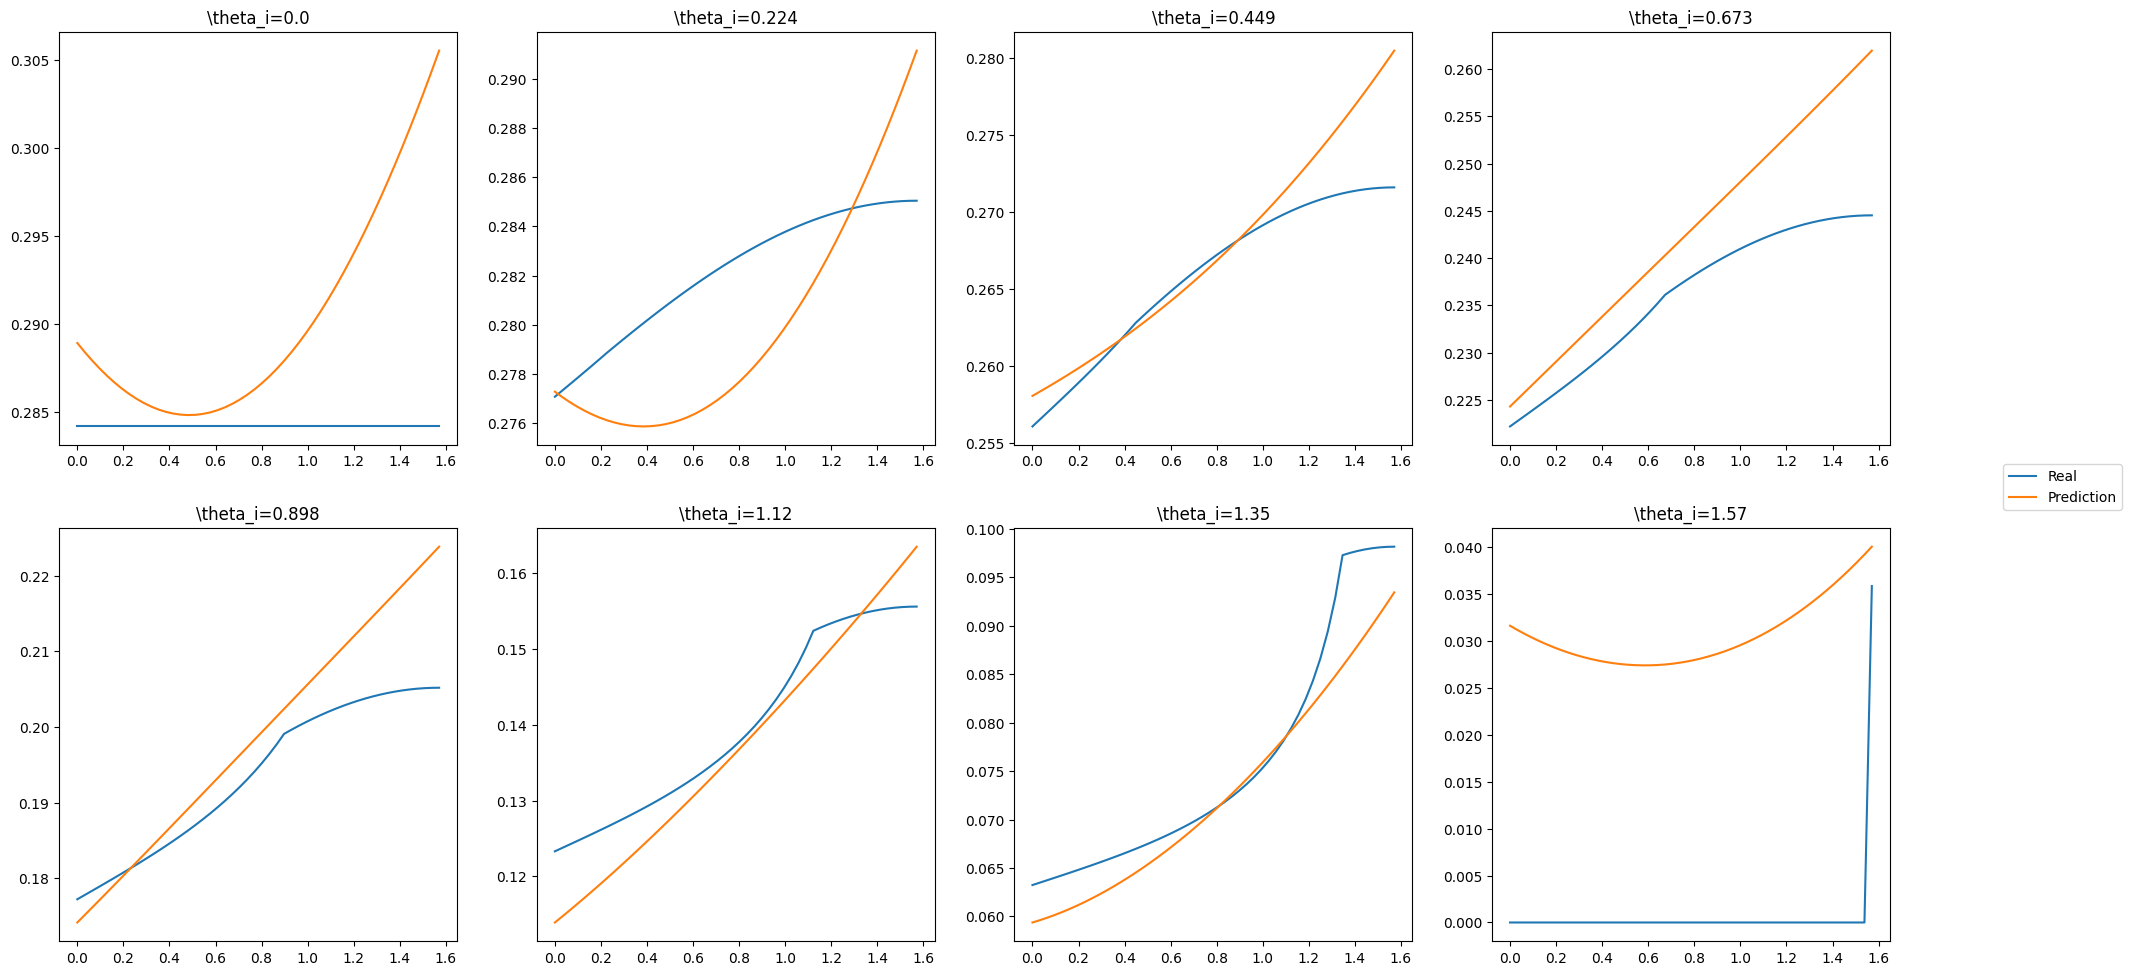

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(
	figsize=(60 * 1 / 2.54, 15 * 2 * 1 / 2.54),
)

axs = [fig.add_subplot(2, 4, i) for i in range(1, 9)]


for n, ax in enumerate(axs):
	theta_i = ((np.pi / 2) / 7) * n
	theta_o = np.linspace(0, np.pi / 2)
	sigma_range = scalars.get('sigma').get('range')
	sigma = (sigma_range[0] + sigma_range[1])/2
	phi_range = angles.get('phi').get('range')
	phi = (phi_range[0] + phi_range[1])/3
	y = list(map(lambda x: func(sigma, theta_i, x, phi), theta_o))
	yy = list(
		map(lambda x: model.model(model.circuit, [sigma, theta_i, x, phi], model.params), theta_o)
	)
	ax.plot(theta_o, y, label='Real')
	ax.plot(theta_o, yy, label='Prediction')
	ax.set_title(f'{r'\theta_i'}={theta_i:.3}')

fig.legend(['Real', 'Prediction'], loc='center right')

fig.show()